In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install keras-drop-block

  Preparing metadata (setup.py) ... - done
  Created wheel for keras-drop-block: filename=keras_drop_block-0.7.0-py3-none-any.whl size=6253 sha256=6e1b5588ffa683ed71a18a4a243bc3c89c08a1b67a9085ca6a85527cd35ff4ab
  Stored in directory: /root/.cache/pip/wheels/7a/5b/37/ffe0a1505f67d295bfec16f93115fc5d114bb7c164fa83d16d
Successfully built keras-drop-block


In [3]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import itertools
import tensorflow
import tensorflow.keras
from tensorflow.keras.applications import ResNet152, Xception,VGG16,EfficientNetB4
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
np.random.seed(123)
print("done")

done


In [4]:
lesion_type_dict = {'akiec': 'Actinic keratoses',
                    'bcc': 'Basal cell carcinoma',
                    'bkl': 'Benign keratosis-like lesions ',
                    'df': 'Dermatofibroma',
                    'nv': 'Melanocytic nevi',
                    'mel': 'Melanoma',
                    'vasc': 'Vascular lesions'}

base_skin_dir = os.path.join('..', 'input')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.groupby(['dx']).count()

,lesion_id,image_id,dx_type,age,sex,localization,path,cell_type,cell_type_idx
dx,,,,,,,,,
akiec,327,327,327,327,327,327,327,327,327
bcc,514,514,514,514,514,514,514,514,514
bkl,1099,1099,1099,1089,1099,1099,1099,1099,1099
df,115,115,115,115,115,115,115,115,115
mel,1113,1113,1113,1111,1113,1113,1113,1113,1113
nv,6705,6705,6705,6660,6705,6705,6705,6705,6705
vasc,142,142,142,142,142,142,142,142,142


In [5]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,100))))
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [6]:
from tensorflow.keras.utils import to_categorical
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.2,random_state=666)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)

In [7]:
#Reshaping the Images into 3 channels (RGB)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [8]:
input_shape = (75, 100, 3)
num_classes = 7
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=4, verbose=1, factor=0.5, min_learning_rate=0.00001)

#Data Generation
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10) 
datagen.fit(x_train)

In [9]:
import keras
EarlyStop = keras.callbacks.EarlyStopping(
               min_delta = 0.001,
               patience = 10 ,
               verbose = 0)

In [10]:
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization
from keras_drop_block import DropBlock2D
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
headModel = baseModel.output

headModel_DO = Dropout(0.5)(headModel)
headModel_DO = BatchNormalization()(headModel_DO)
headModel_DO = AveragePooling2D()(headModel_DO)
headModel_DO = Flatten(name="flatten")(headModel_DO)
headModel_DO = Dense(64, activation="relu")(headModel_DO)
headModel_DO = Dropout(0.5)(headModel_DO)
headModel_DO = Dense(7, activation="softmax")(headModel_DO)
model_DO = Model(inputs=baseModel.input, outputs=headModel_DO)
for layer in baseModel.layers:
    layer.trainable = False
    
model_DO.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 100, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 100, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 100, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 50, 128)       147584    
                                                              

In [11]:
import keras
EarlyStop = keras.callbacks.EarlyStopping(
               min_delta = 0.0001,
               patience = 20 ,
               verbose = 0)

Epoch 1/20


2023-03-01 17:51:27.995517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


73/73 [==============================] - 13s 62ms/step - loss: 1.2484 - accuracy: 0.5888 - val_loss: 1.0444 - val_accuracy: 0.6708
Epoch 2/20
73/73 [==============================] - 4s 52ms/step - loss: 0.9814 - accuracy: 0.6750 - val_loss: 0.9869 - val_accuracy: 0.6820
Epoch 3/20
73/73 [==============================] - 4s 52ms/step - loss: 0.9357 - accuracy: 0.6852 - val_loss: 0.9343 - val_accuracy: 0.6920
Epoch 4/20
73/73 [==============================] - 4s 51ms/step - loss: 0.9031 - accuracy: 0.6935 - val_loss: 0.8985 - val_accuracy: 0.6933
Epoch 5/20
73/73 [==============================] - 4s 51ms/step - loss: 0.8875 - accuracy: 0.6972 - val_loss: 0.8771 - val_accuracy: 0.6995
Epoch 6/20
73/73 [==============================] - 4s 56ms/step - loss: 0.8763 - accuracy: 0.6979 - val_loss: 0.8614 - val_accuracy: 0.7007
Epoch 7/20
73/73 [==============================] - 4s 52ms/step - loss: 0.8494 - accuracy: 0.7039 - val_loss: 0.8419 - val_accuracy: 0.6995
Epoch 8/20
73/73 [=====

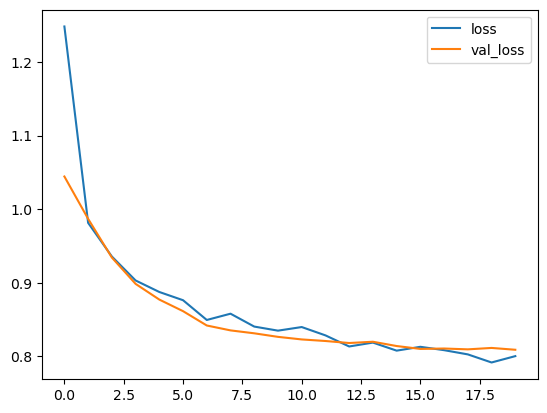

In [12]:
# model_DO.compile(loss="categorical_crossentropy", optimizer=optimizer,
#     metrics=["accuracy"])
model_DO.compile(
    optimizer ='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
# H_DO = model_DO.fit(datagen.flow(x_train,y_train, batch_size=20),
#                              epochs = 50, validation_data = (x_validate,y_validate), callbacks=[learning_rate_reduction])
# history = model_DO.fit(x_train ,
#                     y_train ,
#                     epochs=25 ,
#                     batch_size=128,
#                     validation_data=(x_validate,y_validate))
train = model_DO.fit(x_train,
          y_train,
          batch_size = 100,
          epochs= 20,
          callbacks=[EarlyStop],
          validation_data=(x_validate,y_validate) )
history_df = pd.DataFrame(train.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

Epoch 1/30


2023-03-01 17:53:52.780588: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


73/73 [==============================] - 6s 62ms/step - loss: 0.7910 - accuracy: 0.7226 - val_loss: 0.8106 - val_accuracy: 0.7057
Epoch 2/30
73/73 [==============================] - 4s 52ms/step - loss: 0.7857 - accuracy: 0.7208 - val_loss: 0.8139 - val_accuracy: 0.7070
Epoch 3/30
73/73 [==============================] - 4s 52ms/step - loss: 0.7781 - accuracy: 0.7229 - val_loss: 0.8174 - val_accuracy: 0.7132
Epoch 4/30
73/73 [==============================] - 4s 52ms/step - loss: 0.7730 - accuracy: 0.7275 - val_loss: 0.8085 - val_accuracy: 0.7082
Epoch 5/30
73/73 [==============================] - 4s 54ms/step - loss: 0.7778 - accuracy: 0.7179 - val_loss: 0.8192 - val_accuracy: 0.7032
Epoch 6/30
73/73 [==============================] - 4s 56ms/step - loss: 0.7764 - accuracy: 0.7209 - val_loss: 0.8096 - val_accuracy: 0.7020
Epoch 7/30
73/73 [==============================] - 4s 56ms/step - loss: 0.7756 - accuracy: 0.7221 - val_loss: 0.8122 - val_accuracy: 0.7082
Epoch 8/30
73/73 [======

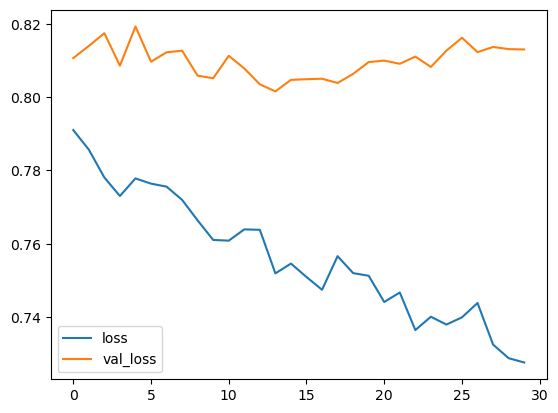

In [13]:
# model_DO.compile(loss="categorical_crossentropy", optimizer=optimizer,
#     metrics=["accuracy"])
model_DO.compile(
    optimizer ='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
# H_DO = model_DO.fit(datagen.flow(x_train,y_train, batch_size=20),
#                              epochs = 50, validation_data = (x_validate,y_validate), callbacks=[learning_rate_reduction])
# history = model_DO.fit(x_train ,
#                     y_train ,
#                     epochs=25 ,
#                     batch_size=128,
#                     validation_data=(x_validate,y_validate))
train = model_DO.fit(x_train,
          y_train,
          batch_size = 100,
          epochs= 30,
          callbacks=[EarlyStop],
          validation_data=(x_validate,y_validate) )
history_df = pd.DataFrame(train.history)
history_df.loc[:, ['loss', 'val_loss']].plot();